<a href="https://colab.research.google.com/github/brunoodon/4_workshop_misp/blob/main/Hunting_automatizado_de_CVE_recentemente_exploradas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#instalando o módulo PyMISP
!pip3 install pymisp

In [13]:
#importando as bibliotecas necessárias
import pandas as pd
import requests
import numpy as np
import csv
import json
import datetime
import time
import statistics
from pandas.io.parsers import python_parser
from pymisp import MISPEvent, MISPObject, PyMISP, ExpandedPyMISP, MISPSharingGroup
#url dos exploits do CISA
url_cisa = 'https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv'
#url do inventário de ativos do cliente
url_inventory = 'https://raw.githubusercontent.com/brunoodon/4_workshop_misp/main/assets.csv'
#url do MISP
url_misp = 'https://misp.brunoodon.com.br'
#authkey de usuário habilitado para criar eventos no MISP
misp_key = '73RhcpLzFq38Ts5vLO0xhlcF4zEbRFJih8iRiKdw'
#url do dataset de vulnerabilidades recentemente exploradas
url_cve = 'https://raw.githubusercontent.com/brunoodon/mvp-sprint1/main/known_exploited_vulnerabilities.csv'
#url do Elastic
url_es = 'http://mvp-puc.brunoodon.com.br:9200/alerts/_doc'

In [14]:
#lendo e dando 'print' no dataset do inventário do ativos do cliente
inventory = pd.read_csv(url_inventory)
display(inventory)

,application,ip,hostname,dep
0,Exchange Server,172.16.0.20,mail.fakecomp.com,TI
1,iOS,10.0.0.200,fake-cellphone,Vendas
2,Windows,10.0.0.150,desktop01,Vendas
3,Chromium,10.0.0.150,desktop01,Vendas
4,Firefox,10.0.0.150,desktop01,Vendas
...,...,...,...,...
58,Pulse Connect Secure,10.30.2.1,vpn-srv,TI
59,Pulse Connect Secure,10.30.2.1,vpn-srv,TI
60,Pulse Connect Secure,10.30.2.1,vpn-srv,TI
61,Pulse Connect Secure,10.30.2.1,vpn-srv,TI


In [ ]:
#lendo e dando 'print' no dataset de vulnerabilidades com exploit recente
exploited_cve = pd.read_csv(url_cve)
display(exploited_cve)

,CVE ID,Vendor Project,Product,Vulnerability Name,Date Added,Short Description,Required Action,Due Date,Notes
0,CVE-2022-42827,Apple,iOS and iPadOS,Apple iOS and iPadOS Out-of-Bounds Write Vulne...,10/25/2022,Apple iOS and iPadOS kernel contain an out-of-...,Apply updates per vendor instructions.,11/15/2022,https://support.apple.com/en-us/HT213489
1,CVE-2022-41352,Zimbra,Collaboration (ZCS),Zimbra Collaboration (ZCS) Arbitrary File Uplo...,10/20/2022,Zimbra Collaboration (ZCS) allows an attacker ...,Apply updates per vendor instructions.,11/10/2022,https://wiki.zimbra.com/wiki/Security_Center
2,CVE-2022-41082,Microsoft,Exchange Server,Microsoft Exchange Server Remote Code Executio...,9/30/2022,Microsoft Exchange Server contains an unspecif...,Apply updates per vendor instructions.,10/21/2022,https://msrc-blog.microsoft.com/2022/09/29/cus...
3,CVE-2022-41040,Microsoft,Exchange Server,Microsoft Exchange Server Server-Side Request ...,9/30/2022,Microsoft Exchange Server allows for server-si...,Apply updates per vendor instructions.,10/21/2022,https://msrc-blog.microsoft.com/2022/09/29/cus...
4,CVE-2022-41033,Microsoft,Windows COM+ Event System Service,Microsoft Windows COM+ Event System Service Pr...,10/11/2022,Microsoft Windows COM+ Event System Service co...,Apply updates per vendor instructions.,11/1/2022,https://msrc.microsoft.com/update-guide/en-US/...
...,...,...,...,...,...,...,...,...,...
844,CVE-2006-2492,Microsoft,Word,Microsoft Word Malformed Object Pointer Vulner...,6/8/2022,Microsoft Word and Microsoft Works Suites cont...,Apply updates per vendor instructions.,6/22/2022,NaN
845,CVE-2006-1547,Apache,Struts 1,Apache Struts 1 ActionForm Denial-of-Service V...,1/21/2022,ActionForm in Apache Struts versions before 1....,Apply updates per vendor instructions.,7/21/2022,NaN
846,CVE-2005-2773,Hewlett Packard (HP),OpenView Network Node Manager,HP OpenView Network Node Manager Remote Code E...,3/25/2022,HP OpenView Network Node Manager could allow a...,Apply updates per vendor instructions.,4/15/2022,NaN
847,CVE-2004-0210,Microsoft,Windows,Microsoft Windows Privilege Escalation Vulnera...,3/3/2022,A privilege elevation vulnerability exists in ...,Apply updates per vendor instructions.,3/24/2022,NaN


In [11]:
#percorrendo cada linha do dataset de inventário de ativos do cliente
for a in range(len(inventory)):
  application=inventory.values[a][0]
  ip=inventory.values[a][1]
  hostname=inventory.values[a][2]
  dep=inventory.values[a][3]
  #criando uma variável com a data atual para inserirmos como parte do nome do evento
  today=str(datetime.date.today())
  #fazendo a busca dos registros do dataset de vulnerabilidades exploradas onde o campo 'Product' contém o nome da aplicação descrita em cada linha de inventário
  search = exploited_cve.query('Product.str.contains("'+application+'") == True', engine="python")
  misp_verifycert = False
  #definindo as características do evento do MISP
  misp = ExpandedPyMISP(url_misp, misp_key, misp_verifycert)
  event = MISPEvent()
  event.info = f"Risco de vulnerabilidades no ativo {hostname}|Aplicação: {application} - "+today+""
  event.analysis = "2"
  event.published = True
  event.distribution = "4" #compartilhar com Sharing group
  event.sharing_group_id = "1" #ID do Sharing group que receberá o evento
  event.threat_level_id = "1" #level HIGH
  event.add_tag('Exploited_CVE')#uma tag criada para identificar que este evento tem CVE com exploit
  event.add_tag('tlp:amber+strict') #só a entidade que enviou e a entidade que recebeu podem ter acesso ao avento
  event.add_tag('circl:incident-classification="vulnerability"')#tag que identifica o tipo de ameaça que será compartilhada. Neste caso, uma tag da taxonomia do CIRCL.
  #percorrendo cada resultado dessa busca e atribuíndo os valores às variáveis
  for b in range(len(search)):
      cve=search.values[b][0]
      vendor=search.values[b][1]
      product=search.values[b][2]
      vulnerability_name=search.values[b][3]
      date_added=search.values[b][4]
      short_desc=search.values[b][5]
      due_date=search.values[b][6]
      notes=search.values[b][7]
      #fazendo a consulta do CVE no banco do NVD, para enriquecer o dataset
      url_nvd = 'https://services.nvd.nist.gov/rest/json/cves/2.0?cveId='+cve+''
      r_nvd = requests.get(url_nvd)
      try:
        #lendo o json com o resultado e atribuindo cada resultado de campo às varáveis severity_score e vector_string
        #obs: foi preciso estabelecer 2 possíveis estruturas, uma para cada versão da métrica de severity score (V2 ou V3.1)
        json_nvd = json.loads(r_nvd.text)
        for c in json_nvd['vulnerabilities']:
          cpe = []
          try:
            for d in c['cve']['metrics']['cvssMetricV31']:
              vector_string = d['cvssData']['vectorString']
              #convertendo o campo de severity_score em float
              severity_score = float(d['cvssData']['baseScore'])
          except:
            for d in c['cve']['metrics']['cvssMetricV2']:
              vector_string = d['cvssData']['vectorString']
              severity_score = float(d['cvssData']['baseScore'])
          for b in c['cve']['configurations']:
            for x in b['nodes']:
              for z in x['cpeMatch']:
                cpe.append(z['criteria'])
          #adicionando as CVE, com os detalhes no comentário
          event.add_attribute('vulnerability', str(cve), disable_correlation=True, to_ids=False, comment=f'Severity Score: {severity_score}|Vector String:{vector_string}|Product: {product}')
          print(f'Adicionando a CVE {cve} no evento')
          es_header = {'Content-Type': 'application/json'}
          es_json = {
          'Vulnerability': cve,
          'VulnerabilityName': vulnerability_name,
          'Description': short_desc,
          'IP': ip,
          'CPE': cpe,
          'Vendor': vendor,
          'Hostname': hostname,
          'Application': application,
          'ExploitationVector': vector_string,
          'SeverityScore': float(severity_score),
          'AlertDate': today,
          'Department': dep
          }
          r_es = requests.post(url_es, headers=es_header, verify=False, json=es_json)
          #foi necessário um temporizador porque a API do NVD tem limitação de requests por minuto
          time.sleep(8)
      except:
        print('Nenhuma vulnerabilidade encontrada no ativo')
  event = misp.add_event(event)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Adicionando a CVE CVE-2022-41082 no evento
Adicionando a CVE CVE-2022-41040 no evento
Adicionando a CVE CVE-2021-34523 no evento
Adicionando a CVE CVE-2021-34473 no evento
Adicionando a CVE CVE-2021-33766 no evento
Adicionando a CVE CVE-2021-31207 no evento
Adicionando a CVE CVE-2021-27065 no evento
Adicionando a CVE CVE-2021-26858 no evento
Adicionando a CVE CVE-2021-26857 no evento
Adicionando a CVE CVE-2021-26855 no evento
Adicionando a CVE CVE-2020-17144 no evento
Adicionando a CVE CVE-2020-0688 no evento
Adicionando a CVE CVE-2018-8581 no evento


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/c

Adicionando a CVE CVE-2022-42827 no evento
Adicionando a CVE CVE-2022-32917 no evento
Adicionando a CVE CVE-2022-32894 no evento
Adicionando a CVE CVE-2022-32893 no evento
Adicionando a CVE CVE-2022-22587 no evento
Adicionando a CVE CVE-2021-44168 no evento
Adicionando a CVE CVE-2021-31010 no evento
Adicionando a CVE CVE-2021-30983 no evento
Adicionando a CVE CVE-2021-30869 no evento
Adicionando a CVE CVE-2021-30860 no evento
Adicionando a CVE CVE-2021-30858 no evento
Adicionando a CVE CVE-2021-30807 no evento
Nenhuma vulnerabilidade encontrada no ativo
Adicionando a CVE CVE-2021-30762 no evento
Adicionando a CVE CVE-2021-30761 no evento
Adicionando a CVE CVE-2021-30666 no evento
Adicionando a CVE CVE-2021-30661 no evento
Adicionando a CVE CVE-2021-1879 no evento
Adicionando a CVE CVE-2021-1871 no evento
Adicionando a CVE CVE-2021-1870 no evento
Adicionando a CVE CVE-2021-1782 no evento
Adicionando a CVE CVE-2020-9934 no evento
Adicionando a CVE CVE-2020-9859 no evento
Adicionando a CV

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'misp.brunoodon.com.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/c

Adicionando a CVE CVE-2022-41033 no evento


KeyboardInterrupt: ignored

# Resultado no MISP

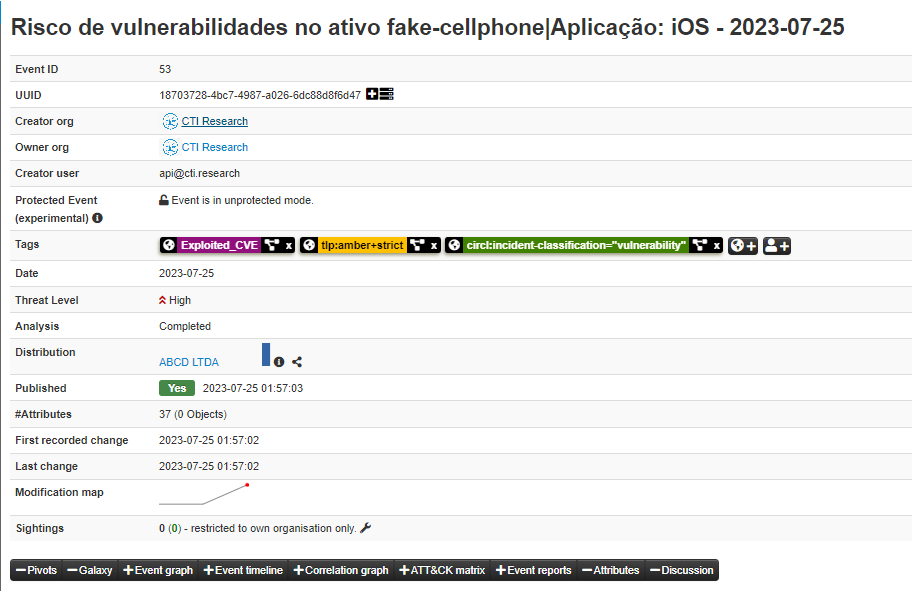



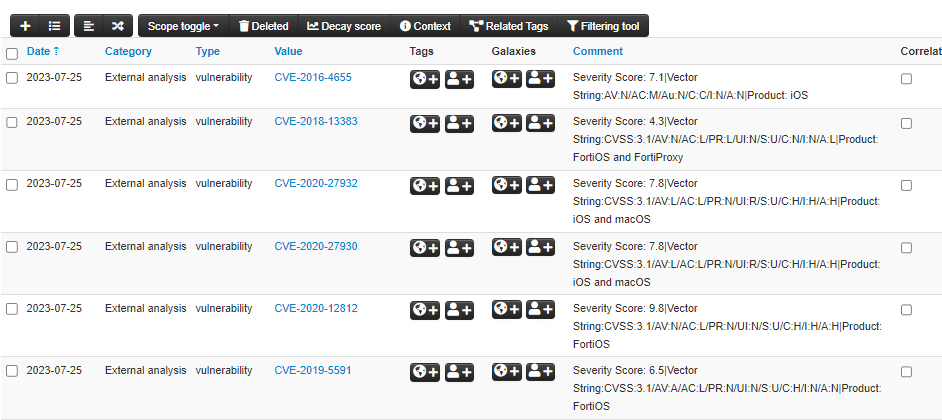